In [1]:

import tqdm
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

from allennlp.models.archival import load_archive
from allennlp.data import DatasetReader, DataIterator
from allennlp.common import Params
from allennlp.nn.util import move_to_device

from kb.include_all import BertPretrainedMaskedLM, KnowBert
%load_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings("ignore")


/nas/home/gujiashe/miniconda3/envs/knowbert/lib/python3.6/site-packages/sklearn/utils/linear_assignment_.py:22: FutureWarning: The linear_assignment_ module is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)
/nas/home/gujiashe/miniconda3/envs/knowbert/lib/python3.6/site-packages/allennlp/data/token_indexers/token_characters_indexer.py:51: UserWarning: You are using the default value (0) of `min_padding_length`, which can cause some subtle bugs (more info see https://github.com/allenai/allennlp/issues/1954). Strongly recommend to set a value, usually the maximum size of the convolutional layer size when using CnnEncoder.
  UserWarning)


In [2]:
evaluation_file = "/nas/home/gujiashe/trans/knowbert_ppl_top10.tsv"
model_archive="knowbert_wiki_wordnet_model"
random_candidates=False
archive = load_archive(model_archive)
model = archive.model
vocab = model.vocab
params = archive.config

model.multitask = False
model.multitask_kg = False
model.cuda()
model.eval()
for p in model.parameters():
    p.requires_grad_(False)


In [3]:
config = Params.from_file("/nas/home/gujiashe/kb/knowbert_wiki_wordnet_model/config.json")

In [4]:

# reader_params = config.pop('dataset_reader')
# if reader_params['type'] == 'multitask_reader':
#     reader_params = reader_params['dataset_readers']['language_modeling']
# # reader_params['num_workers'] = 0
# if random_candidates:
#         for k, v in reader_params['base_reader']['tokenizer_and_candidate_generator']['entity_candidate_generators'].items():
#             v['random_candidates'] = True
# print(reader_params.as_dict())
# dataset_reader = DatasetReader.from_params(Params(reader_params))

iterator = DataIterator.from_params(Params({
        "type": "self_attn_bucket",
        "batch_size_schedule": "base-11gb-fp32",
        "iterator":{
                "type": "bucket",
                "batch_size": 1,
                "sorting_keys": [["tokens", "num_tokens"]],
                "max_instances_in_memory": 2500,
            }
}))
iterator.index_with(model.vocab)
# # instances = reader.read(evaluation_file)
# print("Start!")
reader_params = config.pop('dataset_reader')
if reader_params['type'] == 'multitask_reader':
    reader_params = reader_params['dataset_readers']['language_modeling']
# reader_params['num_workers'] = 0
validation_reader_params = {
    "type": "kg_probe",
    "tokenizer_and_candidate_generator": reader_params['base_reader']['tokenizer_and_candidate_generator'].as_dict()
}
dataset_reader = DatasetReader.from_params(Params(validation_reader_params))

vocab = dataset_reader._tokenizer_and_candidate_generator.bert_tokenizer.vocab
token2word = {}
for k, v in vocab.items():
    token2word[v] = k

duplicate_mentions_cnt:  6777
end of p_e_m reading. wall time: 1.2904848337173462  minutes
p_e_m_errors:  0
incompatible_ent_ids:  0


In [9]:
instances = dataset_reader.read(evaluation_file)
instances[0]

49820it [00:43, 1139.58it/s]


In [10]:
ppls = []
instances = dataset_reader.read(evaluation_file)
for batch_no, batch in enumerate(tqdm.tqdm(iterator(instances, num_epochs=1))):
    b = move_to_device(batch, 0)
    loss = model(**b)
    ppl = np.exp(model.get_metrics()["lm_loss_wgt"])
    # print(ppl)
    ppls.append(ppl)
    model.get_metrics(reset=True)
    # if batch_no % 100 == 0:
    #     print(model.get_metrics())
    # break
# ppls
# print(model.get_metrics())

49820it [00:42, 1159.63it/s]
49820it [30:08, 27.54it/s]


In [11]:
len(ppls)

49820

1
5
4


Text(0, 0.5, 'ppl')

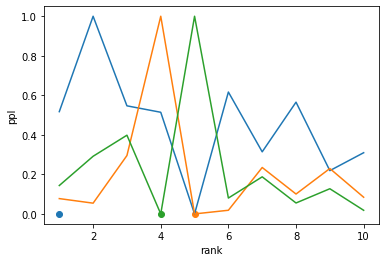

In [14]:
data = pd.read_csv('/nas/home/gujiashe/trans/yago310_ppls_top10.tsv', sep="\t", header=0, index_col=0)

data['ppls'] = ppls

vis = set()
for index in range(8, 11):
    if data["rank"][index*10]>10 or data["rank"][index*10] in vis:
        continue
    vis.add(data["rank"][index*10])
    print(data["rank"][index*10])
    plt.scatter(data["rank"][index*10], 0)
    df = pd.Series(ppls[index*10:index*10 + 10])
    normalized_df=(df-df.min())/(df.max()-df.min())
    plt.plot([i for i in range(1, 11)], normalized_df)
plt.xlabel("rank")
plt.ylabel("ppl")

In [15]:
data.to_csv('/nas/home/gujiashe/trans/yago310_ppls_top10_kb.tsv', sep="\t")

In [1]:
import datetime
import csv
with open('/data02/wikidata-frame-completion/data/birth_table.tsv', 'r') as t:
    i = 0
    sentences_birth = open("sentences_birth.tsv", "w")
    tsv_writer = csv.writer(sentences_birth, delimiter='\t')
    for line in t:
        i+=1
        if i==1:
            continue
        
        person, mother, place, date = line.split('\t')
        if len(mother) == 0:
            continue

        person, lang = person.split("@")
        if lang != "en":
            continue
        person = person.strip("''").split()
        
        
        # print("person: ", person,  "mother: ", mother, "place: ", place, "date: ", date, len(place), len(date))
        # s = "[PERSON] was born on [DATE_OF_BIRTH] at [PLACE_OF_BIRTH]. His mother is [MOTHER]."
        s = person.copy()
        s.extend(["was", "born"])
        spans = []
        spans.append([0, len(person) - 1])
        len_place = len(place)
        len_date = len(date)
        if len_place == 0 and len_date < 2:
            continue
        if len_place > 0:
            place, lang = place.split("@")
            place = place.strip("''").split()
            if lang == "en":
                s.append("at")
                s.extend(place)
                spans.append([len(s) - len(place), len(s) - 1])
        if len_date > 1:
            date = date.split('T')[0][1:]
            year, month, day = date.split('-')
            year = int(year)
            month = int(month)
            day = int(day)
            d = datetime.date(year, month, day)
            date = d.strftime("%d %B %Y").split()
            s.append("on")
            s.extend(date)
            spans.append([len(s) - 3, len(s) - 1])
        s.append('.')
        if len(mother) > 0:
            mother, lang = mother.split("@")
            if lang == "en":
                mother = mother.strip("''").split()
                s.extend(["His", "mother", "is"])
                s.extend(mother)
                spans.append([len(s) - len(mother), len(s) - 1])
        # print(s)
        
        s = " ".join(s)
        for span in spans:
            tsv_writer.writerow([str(span[0]) + " " +  str(span[1])] + [s])
        # print(spans)
        # print(s)
        # if i>10:
        #     breaks
    sentences_birth.close()
    print(i)

FileNotFoundError: [Errno 2] No such file or directory: '/data02/wikidata-frame-completion/data/birth_table.tsv'

In [13]:
import datetime
import csv
with open('/data02/wikidata-frame-completion/data/birth_table.tsv', 'r') as t:
    i = 0
    sentences_birth = open("sentences_place.tsv", "w")
    tsv_writer = csv.writer(sentences_birth, delimiter='\t')
    for line in t:
        i+=1
        if i==1:
            continue
        
        person, mother, place, date = line.split('\t')
        if len(mother) == 0:
            continue

        person, lang = person.split("@")
        if lang != "en":
            continue
        person = person.strip("''").split()
        
        
        # print("person: ", person,  "mother: ", mother, "place: ", place, "date: ", date, len(place), len(date))
        # s = "[PERSON] was born on [DATE_OF_BIRTH] at [PLACE_OF_BIRTH]. His mother is [MOTHER]."
        s = person.copy()
        s.extend(["was", "born"])
        spans = []
        # spans.append([0, len(person) - 1])
        len_place = len(place)
        len_date = len(date)
        if len_place == 0 and len_date < 2:
            continue
        if len_place > 0:
            place, lang = place.split("@")
            place = place.strip("''").split()
            if lang == "en":
                s.append("at")
                s.extend(place)
                spans.append([len(s) - len(place), len(s) - 1])
        if len_date > 1:
            date = date.split('T')[0][1:]
            year, month, day = date.split('-')
            year = int(year)
            month = int(month)
            day = int(day)
            d = datetime.date(year, month, day)
            date = d.strftime("%d %B %Y").split()
            s.append("on")
            s.extend(date)
            # spans.append([len(s) - 3, len(s) - 1])
        s.append('.')
        if len(mother) > 0:
            mother, lang = mother.split("@")
            if lang == "en":
                mother = mother.strip("''").split()
                s.extend(["His", "mother", "is"])
                s.extend(mother)
                # spans.append([len(s) - len(mother), len(s) - 1])
        # print(s)
        
        s = " ".join(s)
        for span in spans:
            tsv_writer.writerow([str(span[0]) + " " +  str(span[1])] + [s])
        # print(spans)
        # print(s)
        # if i>10:
        #     breaks
    sentences_birth.close()


In [22]:
import datetime
import csv
with open('/data02/wikidata-frame-completion/data/birth_table1.tsv', 'r') as t:
    i = 0
    sentences_birth = open("sentences_birth.tsv", "w")
    tsv_writer = csv.writer(sentences_birth, delimiter='\t')

    for line in t:
        i+=1
        if i==1:
            continue
        
        person, mother, place, date = line.split('\t')
        if len(mother) == 0:
            continue
        def process(raw):
            raw = raw.split("@")
            content, lang = raw
            content = content.strip("''").split()
            return content, lang

        person, lang = process(person)
        if lang != "en":
            continue
        mother, lang = process(mother)
        if lang != "en":
            continue        
        place, lang = process(place)
        if lang != "en":
            continue
        
        
        # print("person: ", person,  "mother: ", mother, "place: ", place, "date: ", date, len(place), len(date))
        # “[MOTHER] gave birth to [PERSON] at [PLACE] on [DATE]” 

        idx = 0
        spans = []
        spans.append([idx, idx + len(mother) - 1])
        idx+=len(mother) + 3
        spans.append([idx, idx + len(person) - 1])
        idx+=len(person) + 1
        spans.append([idx, idx + len(place) - 1])
        idx+=len(place) + 1

        date = date.split('T')[0][1:]
        year, month, day = date.split('-')
        year = int(year)
        month = int(month)
        day = int(day)
        d = datetime.date(year, month, day)
        date = d.strftime("%d %B %Y").split()
        spans.append([idx, idx + 2])
        
        s = mother + ["gave", "birth", "to"] + person + ["at"] + place + ["on"] + date + ["."]
        s = " ".join(s)
        for span in spans:
            tsv_writer.writerow([str(span[0]) + " " +  str(span[1])] + [s])
        # print(spans)
        # print(s)
        # if i>10:
        #     breaks
    sentences_birth.close()
    print(i)

6340


In [26]:
import datetime
import csv
with open('/data02/wikidata-frame-completion/data/birth_table1.tsv', 'r') as t:
    i = 0
    sentences_birth = open("sentences_person.tsv", "w")
    tsv_writer = csv.writer(sentences_birth, delimiter='\t')
    for line in t:
        i+=1
        if i==1:
            continue
        
        person, mother, place, date = line.split('\t')
        if len(mother) == 0:
            continue
        def process(raw):
            raw = raw.split("@")
            content, lang = raw
            content = content.strip("''").split()
            return content, lang

        person, lang = process(person)
        if lang != "en":
            continue
        mother, lang = process(mother)
        if lang != "en":
            continue        
        place, lang = process(place)
        if lang != "en":
            continue
        
        
        # print("person: ", person,  "mother: ", mother, "place: ", place, "date: ", date, len(place), len(date))
        # “[MOTHER] gave birth to [PERSON] at [PLACE] on [DATE]” 

        idx = 0
        spans = []
        # spans.append([idx, idx + len(mother) - 1])
        idx+=len(mother) + 3
        spans.append([idx, idx + len(person) - 1])
        idx+=len(person) + 1
        # spans.append([idx, idx + len(place) - 1])
        idx+=len(place) + 1

        date = date.split('T')[0][1:]
        year, month, day = date.split('-')
        year = int(year)
        month = int(month)
        day = int(day)
        d = datetime.date(year, month, day)
        date = d.strftime("%d %B %Y").split()
        # spans.append([idx, idx + 2])
        
        s = mother + ["gave", "birth", "to"] + person + ["at"] + place + ["on"] + date + ["."]
        s = " ".join(s)
        for span in spans:
            tsv_writer.writerow([str(span[0]) + " " +  str(span[1])] + [s])
        # print(spans)
        # print(s)
        # if i>10:
        #     breaks
    sentences_birth.close()
    print(i)

6340


In [ ]:
# kgtk query -i Person0.tsv  -i Mother0.tsv  -i Place0.tsv  -i Date0.tsv  -i labels.en.tsv.gz --match "Person: (q)-[]->(n), Mother: (q)-[]->(m), labels: (m)-[]->(mm), place: (q)-[]->(p), labels: (p)-[]->(pp), date: (q)-[]->(d)" –-return "n as Person, mm as Mother, pp as Place_of_birth, d as Date_of_birth" -o birth_table1.tsv
# kgtk query -i Person0.tsv -i Mother0.tsv -i Place0.tsv -i Date0.tsv -i labels.en.tsv.gz --match "Person: (q)-[]->(n), Mother:(q)-[]->(m), Place: (q)-[]->(p), Date: (q)-[]->(d), labels: (m)-[]->(mm), labels: (p)-[]->(pp)" --return "n as Person, mm as Mother, pp as Place_of_birth, d as Date_of_birth" -o birth_table1.tsv